In [2]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")

image_height/2 =3194.0


# Goal

The goal of this notebook is to check the vertical center calculation using various 0deg files and various profiles

This notebooks takes the profile files produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


In [74]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob

from ipywidgets import interactive
import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


In [75]:
base_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/"
assert os.path.exists(base_folder)  # making sure the base folder exists

## working with various profiles and 3 different 0deg images

In [76]:
list_profile_files = glob.glob(os.path.join(base_folder, '300deg_near_ideal_x_and_y_center') + '/*.txt')
assert len(list_profile_files) > 0
print(f"{list_profile_files =}")

list_profile_files =['/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/300deg_near_ideal_x_and_y_center/horizontal_profile.txt', '/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/300deg_near_ideal_x_and_y_center/vertical_profile.txt']


## load profiles 

In [77]:
data_dict = {}

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=8)
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[1]])
    
    _dict = {'xaxis': xaxis,
             'profile': profile,
             }
    
    data_dict[base_file_name] = _dict

In [78]:
pprint.pprint(data_dict)

{'horizontal_profile.txt': {'profile': array([6978.    , 6782.8335, 6709.8335, ..., 6054.5   , 5954.    ,
       5896.    ]),
                            'xaxis': array([1600, 1601, 1602, ..., 8097, 8098, 8099])},
 'vertical_profile.txt': {'profile': array([13388.667, 13857.833, 13518.5  , ..., 10934.   , 10775.667,
       11121.333]),
                          'xaxis': array([ 500,  501,  502, ..., 5997, 5998, 5999])}}


# fitting horizontal and vertical profile

In [79]:
estimated_center = {'horizontal_profile.txt': 4456,    # 4456
                    'vertical_profile.txt': 2912}

In [88]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

profile_fitted_dict = {}
for _key in data_dict.keys():
    # _key being the profile file name
    
    xaxis = data_dict[_key]['xaxis']
    profile_dict = {}
    yaxis = data_dict[_key]['profile']

    pars = mod.make_params(c=yaxis.mean(),
                  center=estimated_center[_key],
                  sigma=xaxis.std(),
                  amplitude=xaxis.std() * yaxis.ptp())
    out = mod.fit(yaxis, pars, x=xaxis)

    profile_fitted_dict[_key] = {'center_value': round(out.params['center'].value),
                          'center_error': out.params['center'].stderr,
                          'fitting': out.best_fit,
                          }


In [89]:
profile_fitted_dict

{'horizontal_profile.txt': {'center_value': 4603,
  'center_error': None,
  'fitting': array([8808.12437322, 8813.69326438, 8819.26032408, ..., 5851.61674108,
         5845.14933112, 5838.68010207])},
 'vertical_profile.txt': {'center_value': 2726,
  'center_error': 2.2450302098120383,
  'fitting': array([13610.32513809, 13613.00837298, 13615.69127993, ...,
         10787.67986493, 10785.0950832 , 10782.51075467])}}

## Let's plot the center of the beam found over the image 

In [90]:
base_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/experimental_data_to_use/"
image_filename = os.path.join(base_folder, '300deg_nbr1_30s_frames_OB.tif')
assert os.path.exists(image_filename)

In [91]:
image = np.asarray(Image.open(image_filename))

center_x = profile_fitted_dict['horizontal_profile.txt']['center_value']
center_x_error = profile_fitted_dict['horizontal_profile.txt']['center_error']

center_y = profile_fitted_dict['vertical_profile.txt']['center_value']
center_y_error = profile_fitted_dict['vertical_profile.txt']['center_error']



<IPython.core.display.Javascript object>


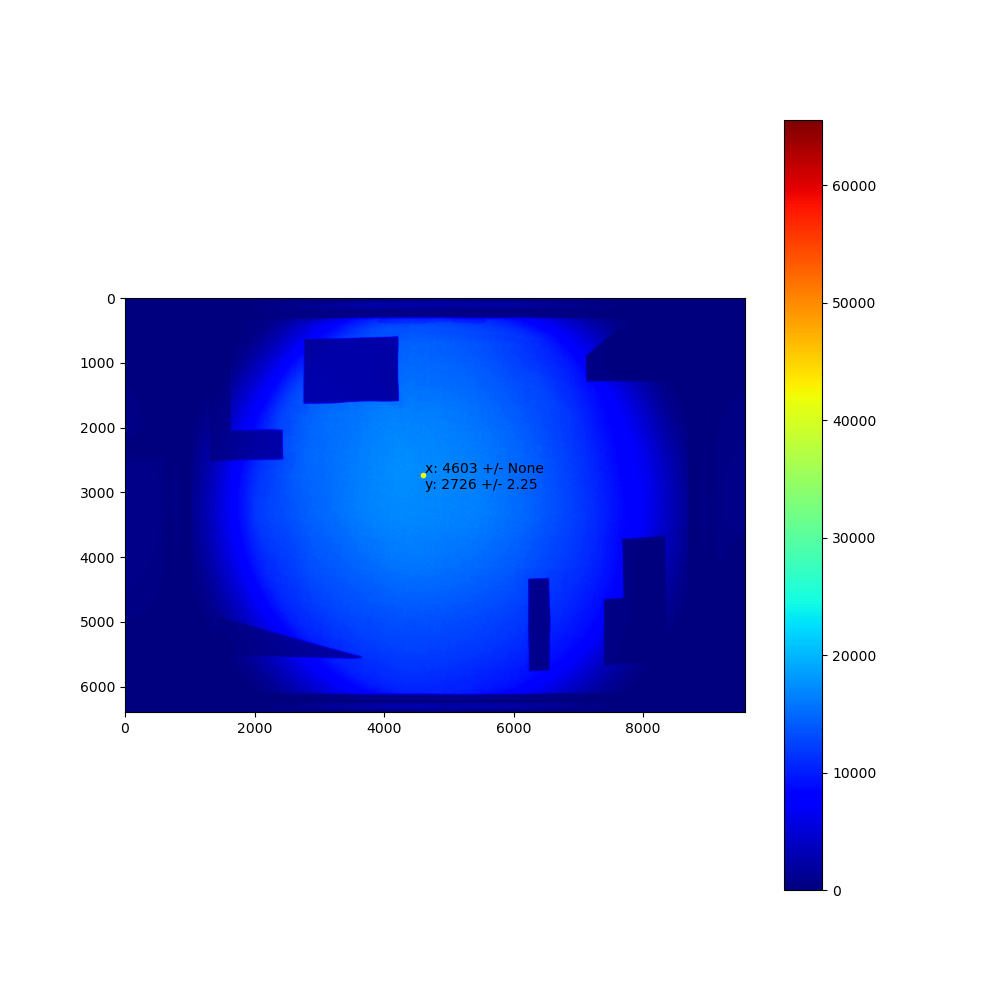

Text(4633, 2756, 'x: 4603 +/- None\ny: 2726 +/- 2.25')

In [92]:
text_offset = 30

plt.figure(0, figsize=(10, 10))
plt.imshow(image, cmap='jet')
plt.errorbar(center_x, center_y, xerr=center_x_error, yerr=center_y_error, color='yellow', ecolor='black', fmt='.')
plt.colorbar()
plt.text(center_x+text_offset, center_y+text_offset,
         f"x: {center_x} +/- {center_x_error}\ny: {center_y} +/- {center_y_error:.2f}",
                 horizontalalignment='left',
         verticalalignment='center'
)


## Let's check the fitting

I'm trying to figure out why the fitting x axis is None!

In [93]:
data_dict

{'horizontal_profile.txt': {'xaxis': array([1600, 1601, 1602, ..., 8097, 8098, 8099]),
  'profile': array([6978.    , 6782.8335, 6709.8335, ..., 6054.5   , 5954.    ,
         5896.    ])},
 'vertical_profile.txt': {'xaxis': array([ 500,  501,  502, ..., 5997, 5998, 5999]),
  'profile': array([13388.667, 13857.833, 13518.5  , ..., 10934.   , 10775.667,
         11121.333])}}

In [94]:
profile_fitted_dict

{'horizontal_profile.txt': {'center_value': 4603,
  'center_error': None,
  'fitting': array([8808.12437322, 8813.69326438, 8819.26032408, ..., 5851.61674108,
         5845.14933112, 5838.68010207])},
 'vertical_profile.txt': {'center_value': 2726,
  'center_error': 2.2450302098120383,
  'fitting': array([13610.32513809, 13613.00837298, 13615.69127993, ...,
         10787.67986493, 10785.0950832 , 10782.51075467])}}

<IPython.core.display.Javascript object>


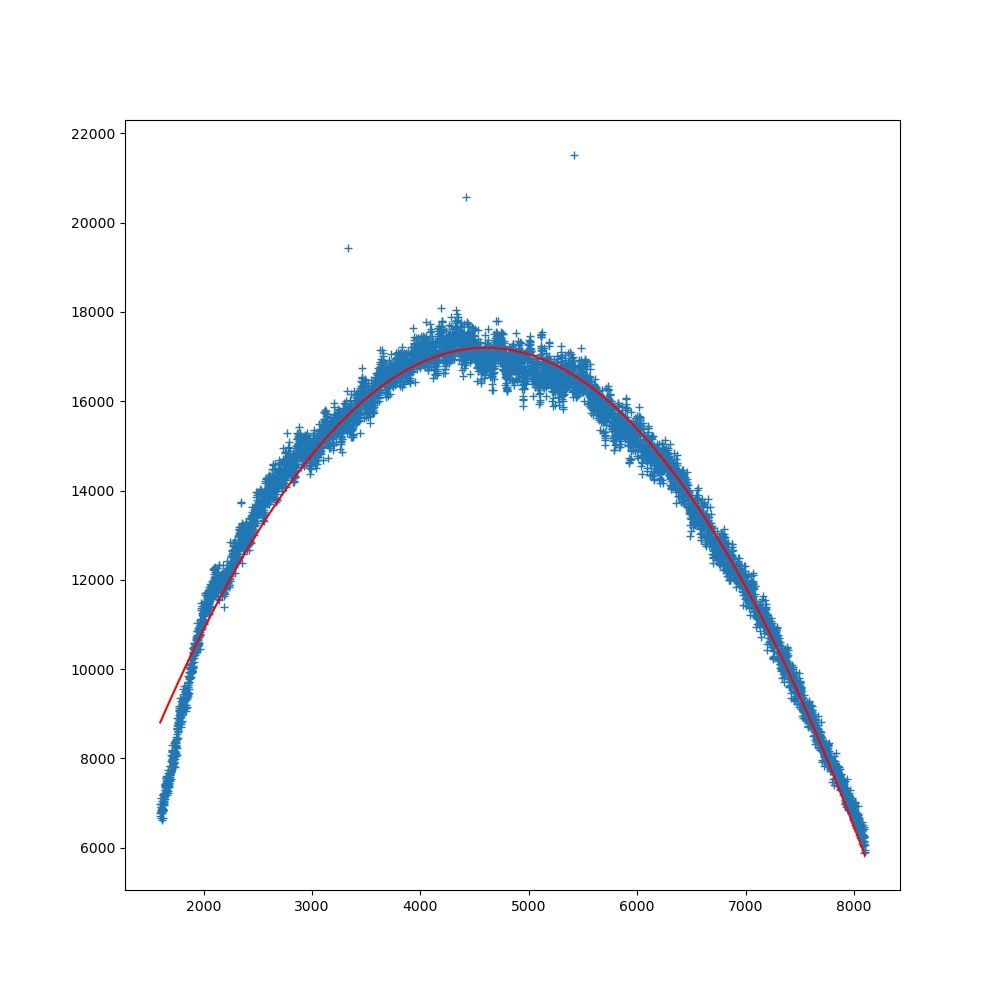

In [95]:
plt.figure(1, figsize=(10, 10))

xaxis = data_dict['horizontal_profile.txt']['xaxis']
yaxis_fitted = profile_fitted_dict['horizontal_profile.txt']['fitting']
yaxis = data_dict['horizontal_profile.txt']['profile']
plt.plot(xaxis, yaxis, '+')
plt.plot(xaxis, yaxis_fitted, 'r')

Maybe we should start the fitting using the range [2148, 8000] and remove the high counts (above 19000)

### Only use range 2148, 8000 

<IPython.core.display.Javascript object>


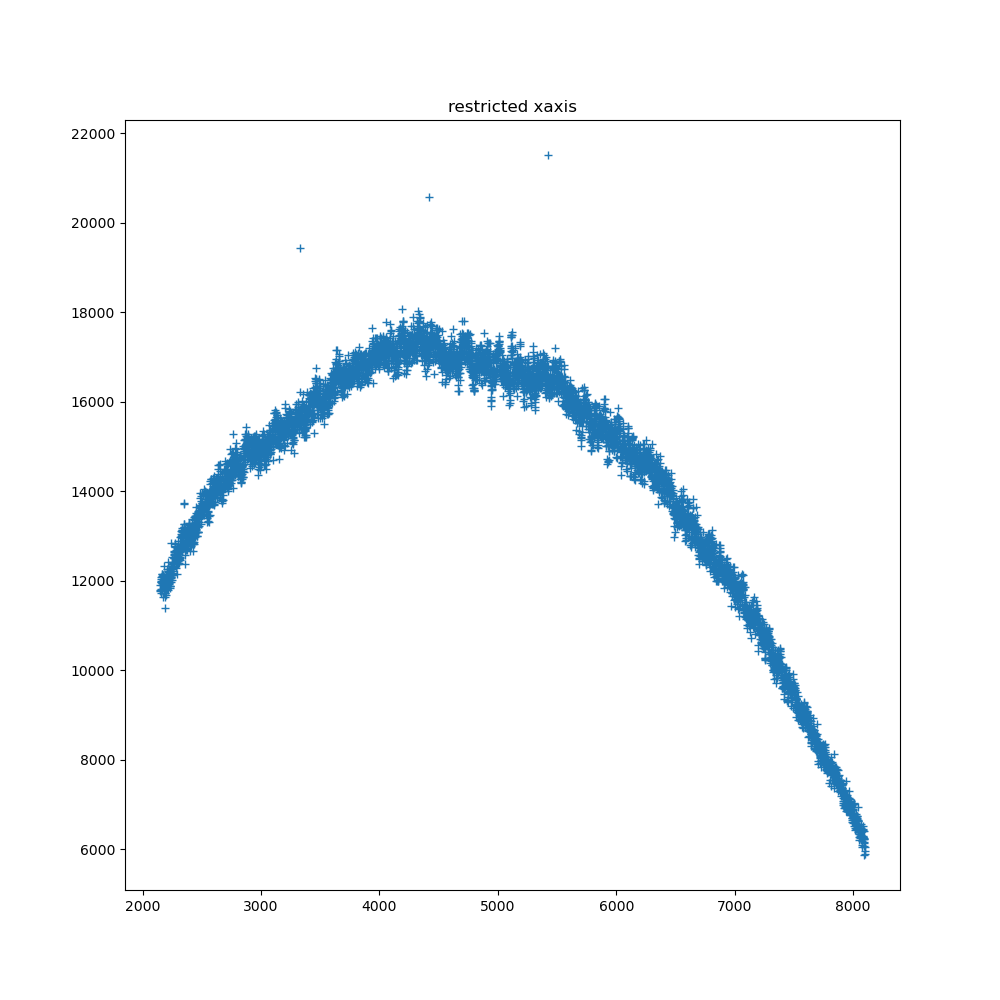

In [96]:
left_index = np.where(xaxis == 2148)[0][0]
new_xaxis = xaxis[left_index:]
new_yaxis = yaxis[left_index: ]

plt.figure(2, figsize=(10, 10))
plt.title("restricted xaxis")

plt.plot(new_xaxis, new_yaxis, '+')


### remove abnormal high counts 

In [97]:
index_above_threshold = np.where(yaxis > 19000)
for index in index_above_threshold:
    yaxis[index] = yaxis[index-1]

data_dict['horizontal_profile.txt']['xaxis'] = new_xaxis
data_dict['horizontal_profile.txt']['profile'] = new_yaxis


<IPython.core.display.Javascript object>


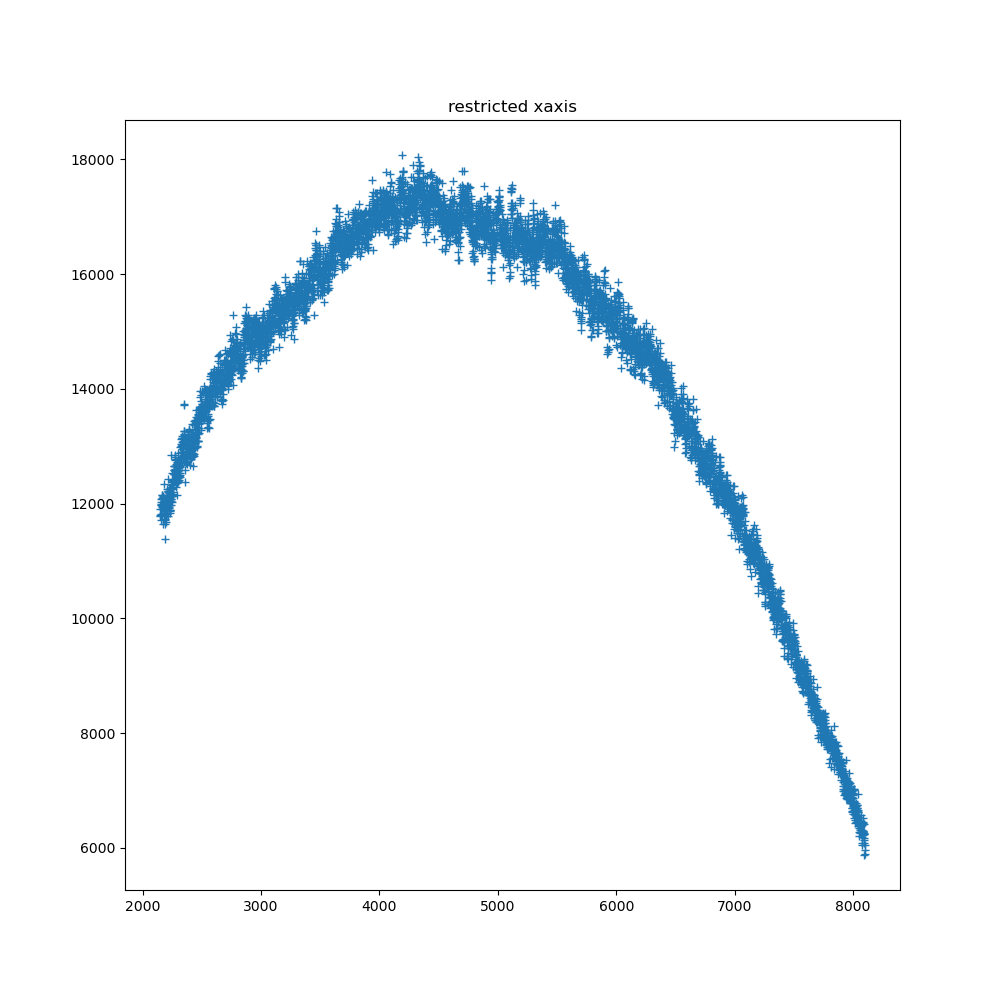

In [98]:
plt.figure(3, figsize=(10, 10))
plt.title("restricted xaxis")

plt.plot(new_xaxis, new_yaxis, '+')


### let's try to fit again 

In [100]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

profile_fitted_dict = {}
for _key in data_dict.keys():
    # _key being the profile file name
    
    xaxis = data_dict[_key]['xaxis']
    profile_dict = {}
    yaxis = data_dict[_key]['profile']

    pars = mod.make_params(c=yaxis.mean(),
                  center=estimated_center[_key],
                  sigma=xaxis.std(),
                  amplitude=xaxis.std() * yaxis.ptp())
    out = mod.fit(yaxis, pars, x=xaxis)

    profile_fitted_dict[_key] = {'center_value': round(out.params['center'].value),
                          'center_error': out.params['center'].stderr,
                          'fitting': out.best_fit,
                          }


<IPython.core.display.Javascript object>


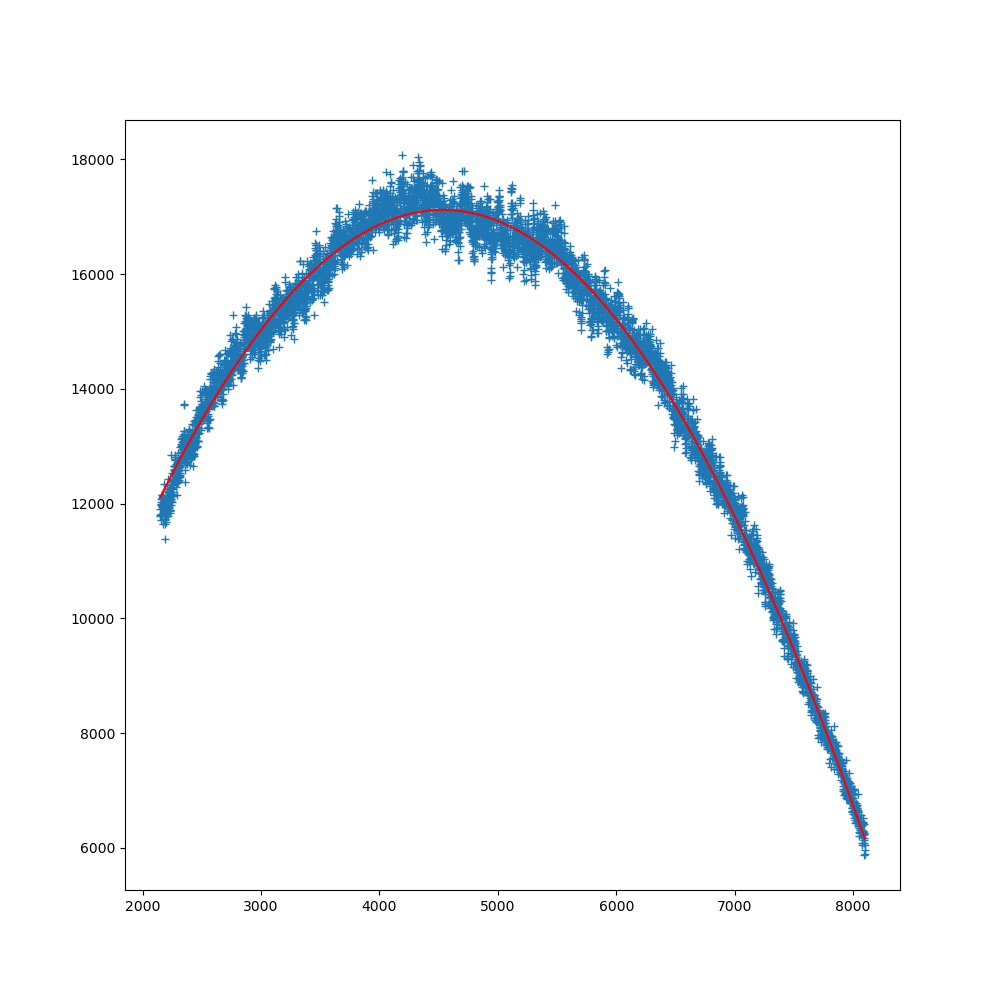

In [101]:
plt.figure(4, figsize=(10, 10))

xaxis = data_dict['horizontal_profile.txt']['xaxis']
yaxis_fitted = profile_fitted_dict['horizontal_profile.txt']['fitting']
yaxis = data_dict['horizontal_profile.txt']['profile']
plt.plot(xaxis, yaxis, '+')
plt.plot(xaxis, yaxis_fitted, 'r')